<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/load_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Images

We will explore loading and preprocessing an image dataset using three different methods.

1. High-level Keras preprocessing utilities and layers.
2. Creating input pipelines using tf.data.
3. Using dataset from the tf repository.

## Setup

In [15]:
import os
import pathlib
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
tf.__version__

'2.3.0'

## Download the flowers dataset

We will work with a dataset of thousands photos of flowers. The flowers dataset contains 5 sub-directories:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```


In [2]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    fname='flower_photos',
    untar=True
)
data_dir = pathlib.Path(data_dir)
data_dir

228818944/228813984 [==============================] - 2s 0us/step


PosixPath('/root/.keras/datasets/flower_photos')

After downloading (218MB), you should now have a copy of the flower photos available. There are 3670 total images:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [4]:
roses = list(data_dir.glob('roses/*'))
print(f'roses count: {len(roses)}')

roses count: 641


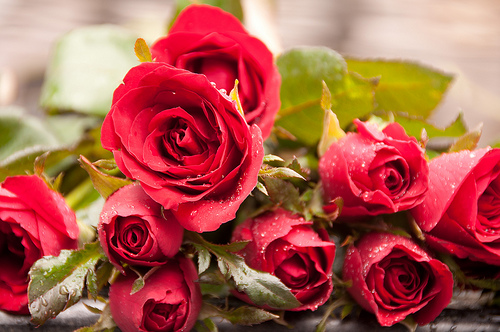

In [5]:
PIL.Image.open(str(roses[0]))

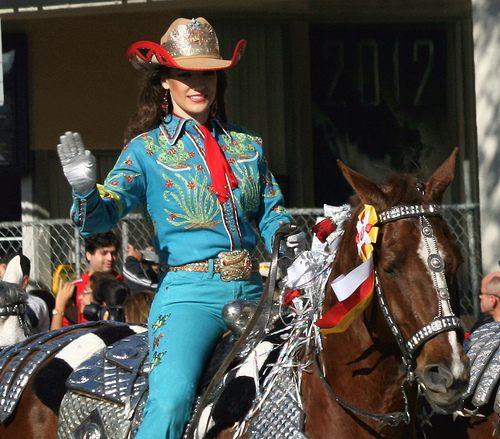

In [6]:
PIL.Image.open(str(roses[1]))

In [7]:
dandelion = list(data_dir.glob('dandelion/*'))
print(f'dandelion count: {len(dandelion)}')

dandelion count: 898


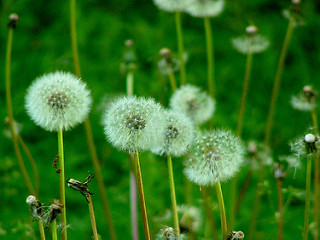

In [8]:
PIL.Image.open(str(dandelion[0]))

## Load using keras.processing

Let's load these images off disk using image_dataset_from_directory.

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimenta and may change.

### Create a dataset

In [9]:
batch_size = 32
img_height = 180
img_width = 180


It's good practive to use a validation split when developing your model. We will use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Visualize the data

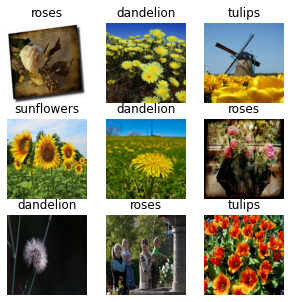

In [13]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

You can train a model using these datasets by passing them to `model.fit`.

In [14]:
image_batch, labels_batch = next(iter(train_ds))
image_batch.shape, labels_batch.shape

(TensorShape([32, 180, 180, 3]), TensorShape([32]))

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

In [21]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[2]
np.min(first_image), np.max(first_image)


(0.0, 1.0)

### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this [tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [23]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255.),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 8s 88ms/step - loss: 1.2545 - accuracy: 0.4455 - val_loss: 1.0902 - val_accuracy: 0.5654
Epoch 2/3
92/92 [==============================] - 2s 22ms/step - loss: 1.0120 - accuracy: 0.5954 - val_loss: 0.9728 - val_accuracy: 0.6063
Epoch 3/3
92/92 [==============================] - 2s 22ms/step - loss: 0.8611 - accuracy: 0.6662 - val_loss: 0.9620 - val_accuracy: 0.6063


## Using tf.data for finer control

The above keras.preprocessing utilities are a convenient way to create a `tf.data.Dataset` from a directory of images. For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [27]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [28]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/4581199679_867652c3f1_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/10386525695_2c38fea555_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/11891885265_ccefec7284_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/9433167170_fa056d3175.jpg'
b'/root/.keras/datasets/flower_photos/roses/2949945463_366bc63079_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [29]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.skip(val_size)

In [30]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

92
23


In [37]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path, _):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [39]:
# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)